# Load libraries

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

# Read train and test data

In [4]:
dfXtrain = pd.read_csv('X.train.csv')
dfXtest = pd.read_csv('X.test.csv')
dfYtrain = pd.read_csv('y.train.csv')
Xtrain = np.array(dfXtrain)
Xtest = np.array(dfXtest)

ytrain = np.array(dfYtrain['label'])

In [5]:
print('Data size:', dfXtrain.shape)
dfXtrain.head()

Data size: (4099, 1330)


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,826,0,0,0,0,0,0,NaN,NaN,0,...,0.0,0.0,0,0.0,1.0,1,0.0,NaN,0.0,0.5
1,15,0,0,0,0,0,0,0.030303,0.083333,0,...,0.0,0.0,1,0.0,0.0,0,0.5,0,0.5,0.0
2,242,0,0,0,0,0,0,NaN,NaN,0,...,1.0,1.0,0,0.5,0.0,0,1.0,0,0.0,0.5
3,1038,0,0,0,0,0,0,NaN,NaN,0,...,0.5,0.5,0,0.0,0.0,0,0.0,0,0.0,0.5
4,971,0,0,0,0,0,0,NaN,NaN,0,...,0.0,0.0,1,0.0,0.5,0,0.0,0,0.0,0.0


# Replace all NaN's in train and test data to most frequent values in train data

In [6]:
Xbig = np.vstack((Xtrain, Xtest))

In [7]:
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imp.fit(Xbig)

Xtrain = imp.transform(Xtrain)
Xtest = imp.transform(Xtest)

# Train Random Forest classifier

In [8]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xtrain, ytrain, test_size=0.5)

In [9]:
from sklearn.metrics import log_loss

In [10]:
def get_score_list(X, y, clf):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        predictions.append(tree.predict(X))
        rf_prediction = mean(predictions, axis=0)
        score.append(log_loss(y, rf_prediction))
        if i % 100 == 0:
            print(score[-1])
    return score

In [11]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, prefix, print_train=True):
    clf.fit(X_train, y_train)
    train_score = get_score_list(X_train, y_train, clf)
    test_score = get_score_list(X_test, y_test, clf)
    if print_train:
        plot(train_score, label=prefix + ' train set error')
    plot(test_score, label=prefix + ' test set error')
    xlabel('n_estimators')
    ylabel('LL')
    legend()

1.70251849377
0.0540731456519
0.0543876196754
0.0542572594241
0.0544003570132
0.054271523678
0.0542412547377
0.0541901452607
0.0543314830182
0.0542198635425
4.3300416942
0.242357795653
0.214279861658
0.213000010682
0.211906203229
0.21146240809
0.211488166349
0.211385085502
0.21129718959
0.211685296101


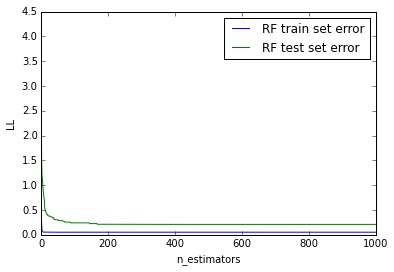

In [31]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=100, n_jobs=-1),
               X_train[:, :330], X_test[:, :330], y_train, y_test,
               prefix='RF')

600 деревьев пойдёт

In [13]:
from sklearn.grid_search import GridSearchCV

In [14]:
def learn(clf, params):
    grid_searcher = GridSearchCV(clf,\
                             params, cv=5, scoring='log_loss', n_jobs=-1)
    grid_searcher.fit(Xtrain, ytrain)

    print(grid_searcher.best_score_)
    print(grid_searcher.best_estimator_)
    
    return grid_searcher

In [32]:
clf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features=100, n_jobs=-1)
clf.fit(Xtrain[:, :330], ytrain)

ypred = clf.predict_proba(Xtest[:, :330])[:, 1]

# Save predictions

In [33]:
dfpred = pd.DataFrame()
dfpred['Id'] = np.arange(len(ypred))
dfpred['Prediction'] = ypred

dfpred.to_csv('y.predicted.csv', index = False)